## Exploratory Data Analysis

This section serves as the foundation for understanding the dataset and its characteristics. The goal is to perform a detailed exploratory data analysis (EDA) to identify dataset properties, potential issues, and prepare insights for the subsequent steps.

---
### Conclusions of the EDA and ideas for going further

1. The spectrograms of jungle and chainsaw audio differ significantly across frequency ranges.
2. The chainsaw spectrogram contains a distinct cepstral component, originating purely from the mechanical engine, which is unnatural and easily separable.
3. When using a MEL spectrogram, the frequency range should be adjusted to maximize sensitivity in the [300-1500] Hz range. Increasing the sampling rate (SR) by a factor of 3 ensures that the chainsaw's frequency ranges are well-amplified.
4. The MFCC features should capture the relevant cepstral components after adapting the MEL scale to the appropriate range.
5. Averaging the spectrograms over the audio files can reduce noise, similar to the Welch periodogram approach.
6. The cepstral spectrum becomes much cleaner when the initial spectrum is filtered to the [300-1500] Hz range.
7. Simple models based on cepstral spectrum can effectively distinguish between the two classes.
8. The initial signal can be decimated to focus on the frequency ranges specific to the engine sounds.
9. Many audio samples are heavily noisy, then it seems difficult to track the time-evolution of the tonal component in quefrency domain.
10. Suggested feature pipeline: Decimate the signal to set fmax at 3 kHz or 1.5 kHz (with a factor of 2 or 4), compute the Spectrogram, then calculate the Mean(FFT(|Spectrogram|)).

---
### Fun discoveries
The quefrency analysis allows us to observe the following:
- The microphone measurement was likely conducted in proximity (~10cm) of a reflective object (the branch of the tree?), as suggested by the first component in the quefrency domain.
- The chainsaw is likely a 4-stroke model, as suggested by the observation of 4 harmonics.
- The average speed of the chainsaw engine is estimated to be around 7000 Revolutions Per Minute (RPM).
---
### Reference
**A History of Cepstrum Analysis and its Application to Mechanical Problems**- Robert B Randall
https://surveillance7.sciencesconf.org/conference/surveillance7/01_a_history_of_cepstrum_analysis_and_its_application_to_mechanical_problems.pdf


In [1]:
from datasets import load_dataset
import warnings
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import numpy as np
from collections import Counter

warnings.filterwarnings("ignore")

/home/tlemagueresse/Documents/07_Perso/all_envs_perso/frugalai_sub_3_11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LABELS = {0: "chainsaw", 1: "environment"}

In [3]:
dataset = load_dataset("rfcx/frugalai")
train_test = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = train_test["train"]
train_label = train_dataset["label"]
val_dataset = train_test["test"]
val_label = val_dataset["label"]

Using the latest cached version of the dataset since rfcx/frugalai couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/tlemagueresse/.cache/huggingface/datasets/rfcx___frugalai/default/0.0.0/a14fd5b7a22d5c03781db9e270162d946a49a99e (last modified on Fri Jan 24 14:21:40 2025).


In [4]:
lengths_counter = Counter()
sampling_rates_counter = Counter()

for example in train_dataset:
    audio = example["audio"]
    lengths_counter[audio["array"].shape[0]] += 1
    sampling_rates_counter[audio["sampling_rate"]] += 1

print("Total audios in train:", len(train_dataset))
print("\nUnique lengths distribution:")
for length, count in lengths_counter.items():
    print(f"  Length: {length} -> Count: {count}")

print("\nUnique sampling rates distribution:")
for rate, count in sampling_rates_counter.items():
    print(f"  Sampling rate: {rate} Hz -> Count: {count}")

Total audios in train: 28221

Unique lengths distribution:
  Length: 36000 -> Count: 26327
  Length: 72000 -> Count: 1522
  Length: 29760 -> Count: 4
  Length: 25440 -> Count: 319
  Length: 21120 -> Count: 3
  Length: 26880 -> Count: 13
  Length: 24960 -> Count: 1
  Length: 31680 -> Count: 1
  Length: 20640 -> Count: 1
  Length: 42240 -> Count: 1
  Length: 65280 -> Count: 6
  Length: 18240 -> Count: 1
  Length: 53760 -> Count: 6
  Length: 33600 -> Count: 1
  Length: 29280 -> Count: 2
  Length: 20160 -> Count: 1
  Length: 28320 -> Count: 1
  Length: 33120 -> Count: 1
  Length: 23040 -> Count: 1
  Length: 9393 -> Count: 1
  Length: 32640 -> Count: 1
  Length: 24000 -> Count: 2
  Length: 0 -> Count: 2
  Length: 27840 -> Count: 1
  Length: 22080 -> Count: 1
  Length: 18720 -> Count: 1

Unique sampling rates distribution:
  Sampling rate: 12000 Hz -> Count: 26686
  Sampling rate: 24000 Hz -> Count: 1535


### Audio signals

In [5]:
SR = 12000

In [6]:
sig_environment = dataset["train"][0]
audio_environment = sig_environment["audio"]["array"]
label = sig_environment["label"]
print(LABELS[label])
import IPython.display as ipd

ipd.Audio(audio_environment, rate=sig_environment["audio"]["sampling_rate"])

environment


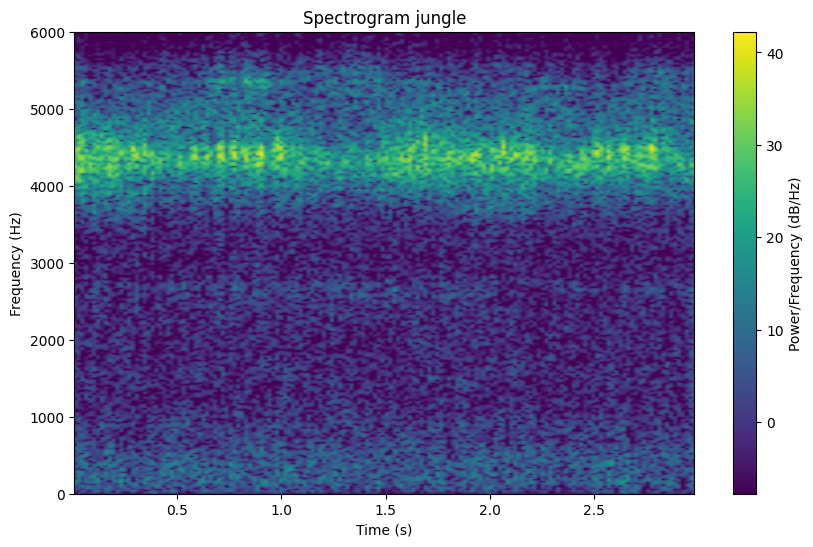

In [7]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

f, t, Sxx = spectrogram(audio_environment, fs=sig_environment["audio"]["sampling_rate"], nfft=1024)
Sxx_db = 10 * np.log10(np.abs(Sxx) / 4e-10)
dynamics = 50  # db
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, Sxx_db, shading="gouraud", vmin=np.max(Sxx_db) - dynamics)
plt.colorbar(label="Power/Frequency (dB/Hz)")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.title("Spectrogram jungle")
plt.show()

In [8]:
sig_chainsaw = dataset["train"][1]
audio_chainsaw = sig_chainsaw["audio"]["array"]
label = sig_chainsaw["label"]
print(LABELS[label])
import IPython.display as ipd

ipd.Audio(audio_chainsaw, rate=sig_chainsaw["audio"]["sampling_rate"])

chainsaw


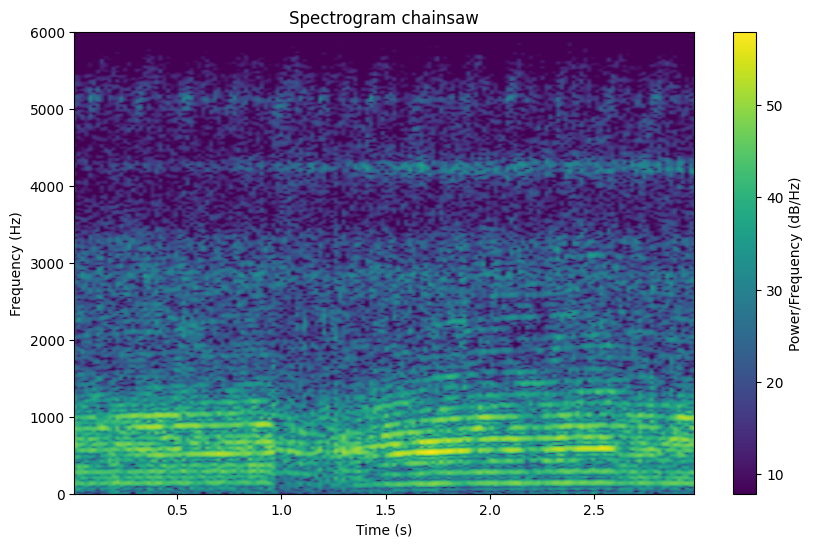

In [9]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

f, t, Sxx = spectrogram(audio_chainsaw, fs=sig_chainsaw["audio"]["sampling_rate"], nfft=1024)
Sxx_db = 10 * np.log10(np.abs(Sxx) / 4e-10)
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, Sxx_db, shading="gouraud", vmin=np.max(Sxx_db) - dynamics)
plt.colorbar(label="Power/Frequency (dB/Hz)")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.title("Spectrogram chainsaw")
plt.show()

### Statistical analysis of sprectrum

In [10]:
n_samples = 2500
label_environment_dataset = (
    dataset["train"].filter(lambda x: x["label"] == 1).shuffle(seed=42).select(range(n_samples))
)
label_chainsaw_dataset = (
    dataset["train"].filter(lambda x: x["label"] == 0).shuffle(seed=42).select(range(n_samples))
)
jungle_audios = [
    d["array"][:36000]
    for d in label_environment_dataset["audio"]
    if (d["array"].shape[0] == 36000) & (d["sampling_rate"] == SR)
]
chainsaw_audios = [
    d["array"][:36000]
    for d in label_chainsaw_dataset["audio"]
    if (d["array"].shape[0] == 36000) & (d["sampling_rate"] == SR)
]

In [11]:
from scipy.signal import welch

f, chainsaw_spectra = welch(chainsaw_audios, fs=SR, nperseg=2048, axis=1)
f, jungle_spectra = welch(jungle_audios, fs=SR, nperseg=2048, axis=1)

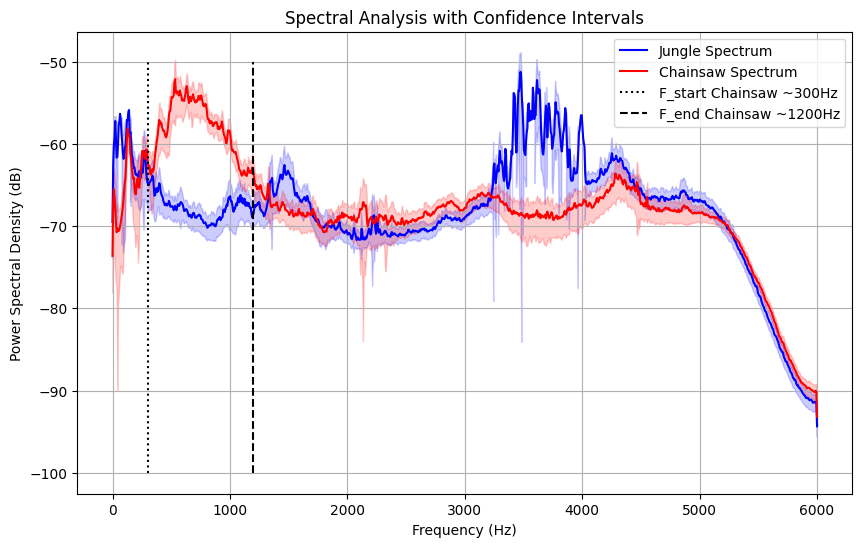

In [12]:
import matplotlib.pyplot as plt
import numpy as np

mean_jungle_spectra = np.mean(jungle_spectra, axis=0)
mean_chainsaw_spectra = np.mean(chainsaw_spectra, axis=0)
ci_jungle_spectra = 1.96 * np.std(jungle_spectra, axis=0) / np.sqrt(jungle_spectra.shape[0])
ci_chainsaw_spectra = 1.96 * np.std(chainsaw_spectra, axis=0) / np.sqrt(chainsaw_spectra.shape[0])

mean_jungle_spectra_db = 10 * np.log10(mean_jungle_spectra)
ci_jungle_spectra_lower = 10 * np.log10(mean_jungle_spectra - ci_jungle_spectra)
ci_jungle_spectra_upper = 10 * np.log10(mean_jungle_spectra + ci_jungle_spectra)

mean_chainsaw_spectra_db = 10 * np.log10(mean_chainsaw_spectra)
ci_chainsaw_spectra_lower = 10 * np.log10(mean_chainsaw_spectra - ci_chainsaw_spectra)
ci_chainsaw_spectra_upper = 10 * np.log10(mean_chainsaw_spectra + ci_chainsaw_spectra)

plt.figure(figsize=(10, 6))
plt.plot(f, mean_jungle_spectra_db, label="Jungle Spectrum", color="blue")
plt.fill_between(f, ci_jungle_spectra_lower, ci_jungle_spectra_upper, color="blue", alpha=0.2)
plt.plot(f, mean_chainsaw_spectra_db, label="Chainsaw Spectrum", color="red")
plt.fill_between(f, ci_chainsaw_spectra_lower, ci_chainsaw_spectra_upper, color="red", alpha=0.2)
plt.vlines(x=300, ymin=-100, ymax=-50, color="black", linestyles="dotted", label="F_start Chainsaw ~300Hz")
plt.vlines(x=1200, ymin=-100, ymax=-50, color="black", linestyles="dashed", label="F_end Chainsaw ~1200Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB)")
plt.title("Spectral Analysis with Confidence Intervals")
plt.legend()
plt.grid(True)
plt.show()

The spectrum signature is well separable in average.

### @ 24000Hz

In [24]:
jungle_audios_24k = [
    d["array"][:72000]
    for d in label_environment_dataset["audio"]
    if (d["array"].shape[0] == 72000) & (d["sampling_rate"] == 2*SR)
]
chainsaw_audios_24k = [
    d["array"][:72000]
    for d in label_chainsaw_dataset["audio"]
    if (d["array"].shape[0] == 72000) & (d["sampling_rate"] == 2*SR)
]

In [25]:
print(len(jungle_audios_24k))

47


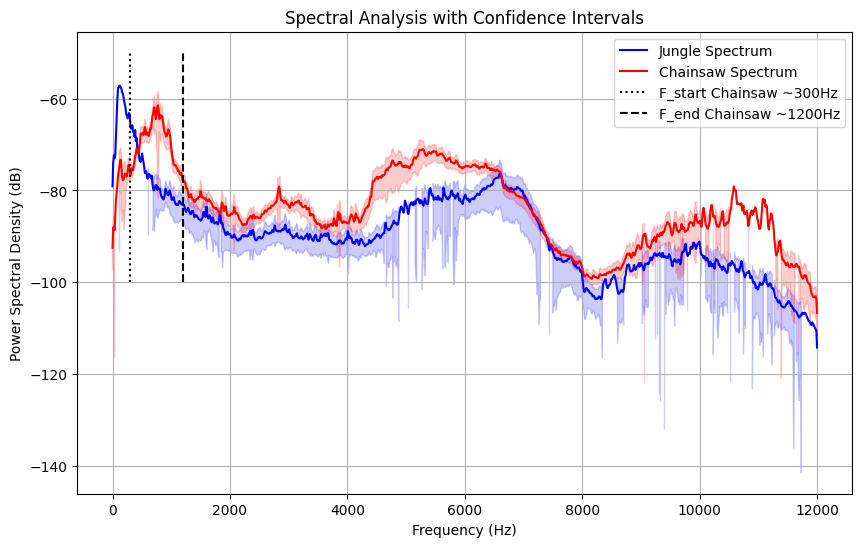

In [26]:
from scipy.signal import welch

f, chainsaw_spectra_24khz = welch(chainsaw_audios_24k, fs=SR*2, nperseg=2048, axis=1)
f, jungle_spectra_24khz = welch(jungle_audios_24k, fs=SR*2, nperseg=2048, axis=1)

import matplotlib.pyplot as plt
import numpy as np

mean_jungle_spectra_24khz = np.mean(jungle_spectra_24khz, axis=0)
mean_chainsaw_spectra_24khz = np.mean(chainsaw_spectra_24khz, axis=0)
ci_jungle_spectra_24khz = 1.96 * np.std(jungle_spectra_24khz, axis=0) / np.sqrt(jungle_spectra_24khz.shape[0])
ci_chainsaw_spectra_24khz = 1.96 * np.std(chainsaw_spectra_24khz, axis=0) / np.sqrt(chainsaw_spectra_24khz.shape[0])

mean_jungle_spectra_24khz_db = 10 * np.log10(mean_jungle_spectra_24khz)
ci_jungle_spectra_24khz_lower = 10 * np.log10(mean_jungle_spectra_24khz - ci_jungle_spectra_24khz)
ci_jungle_spectra_24khz_upper = 10 * np.log10(mean_jungle_spectra_24khz + ci_jungle_spectra_24khz)

mean_chainsaw_spectra_24khz_db = 10 * np.log10(mean_chainsaw_spectra_24khz)
ci_chainsaw_spectra_24khz_lower = 10 * np.log10(mean_chainsaw_spectra_24khz - ci_chainsaw_spectra_24khz)
ci_chainsaw_spectra_24khz_upper = 10 * np.log10(mean_chainsaw_spectra_24khz + ci_chainsaw_spectra_24khz)

plt.figure(figsize=(10, 6))
plt.plot(f, mean_jungle_spectra_24khz_db, label="Jungle Spectrum", color="blue")
plt.fill_between(f, ci_jungle_spectra_24khz_lower, ci_jungle_spectra_24khz_upper, color="blue", alpha=0.2)
plt.plot(f, mean_chainsaw_spectra_24khz_db, label="Chainsaw Spectrum", color="red")
plt.fill_between(f, ci_chainsaw_spectra_24khz_lower, ci_chainsaw_spectra_24khz_upper, color="red", alpha=0.2)
plt.vlines(x=300, ymin=-100, ymax=-50, color="black", linestyles="dotted", label="F_start Chainsaw ~300Hz")
plt.vlines(x=1200, ymin=-100, ymax=-50, color="black", linestyles="dashed", label="F_end Chainsaw ~1200Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB)")
plt.title("Spectral Analysis with Confidence Intervals")
plt.legend()
plt.grid(True)
plt.show()

It is worth noting that the 24 kHz signal should be easier to detect, as its high-frequency component differs significantly from the environmental sounds.

### Mel spectrogram

In [13]:
from librosa.filters import mel


def apply_mel_scale(welch_spectra, sr, n_mels):
    n_fft = (welch_spectra.shape[1] - 1) * 2
    mel_filter_bank = mel(sr=sr, n_fft=n_fft, n_mels=n_mels, fmax=sr / 2)
    mel_spectra = np.dot(mel_filter_bank, welch_spectra.T)
    mel_frequencies = np.linspace(0, sr / 2, n_mels)

    return mel_frequencies, mel_spectra.T

In [14]:
n_mels = 128  # Adjust number of MEL bands as needed
mel_frequencies, mel_jungle_spectra = apply_mel_scale(jungle_spectra, SR, n_mels)
_, mel_chainsaw_spectra = apply_mel_scale(chainsaw_spectra, SR, n_mels)

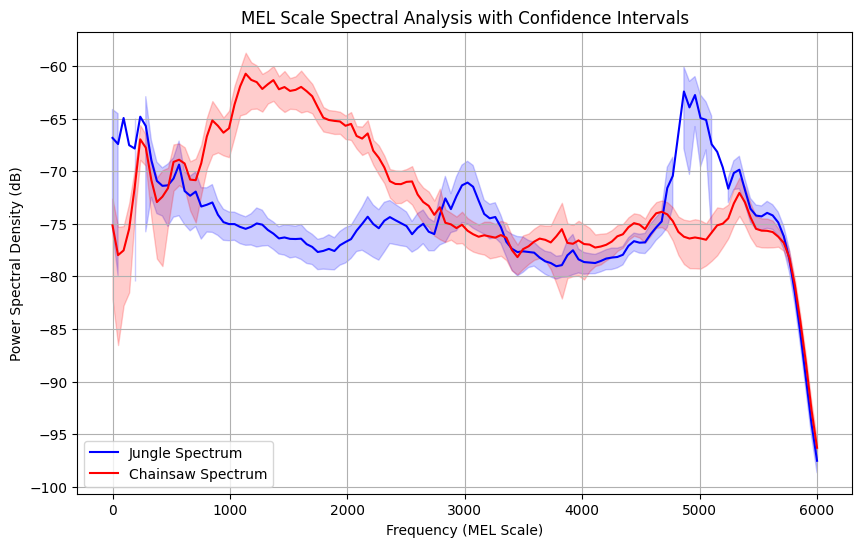

In [15]:
mel_mean_jungle_spectra = np.mean(mel_jungle_spectra, axis=0)
mel_mean_chainsaw_spectra = np.mean(mel_chainsaw_spectra, axis=0)
ci_jungle_spectra = 1.96 * np.std(mel_jungle_spectra, axis=0) / np.sqrt(mel_jungle_spectra.shape[0])
ci_chainsaw_spectra = (
    1.96 * np.std(mel_chainsaw_spectra, axis=0) / np.sqrt(mel_chainsaw_spectra.shape[0])
)

mel_mean_jungle_spectra_db = 10 * np.log10(mel_mean_jungle_spectra)
ci_jungle_spectra_lower = 10 * np.log10(mel_mean_jungle_spectra - ci_jungle_spectra)
ci_jungle_spectra_upper = 10 * np.log10(mel_mean_jungle_spectra + ci_jungle_spectra)

mel_mean_chainsaw_spectra_db = 10 * np.log10(mel_mean_chainsaw_spectra)
ci_chainsaw_spectra_lower = 10 * np.log10(mel_mean_chainsaw_spectra - ci_chainsaw_spectra)
ci_chainsaw_spectra_upper = 10 * np.log10(mel_mean_chainsaw_spectra + ci_chainsaw_spectra)

# Plot results on the MEL scale
plt.figure(figsize=(10, 6))
plt.plot(mel_frequencies, mel_mean_jungle_spectra_db, label="Jungle Spectrum", color="blue")
plt.fill_between(
    mel_frequencies, ci_jungle_spectra_lower, ci_jungle_spectra_upper, color="blue", alpha=0.2
)
plt.plot(mel_frequencies, mel_mean_chainsaw_spectra_db, label="Chainsaw Spectrum", color="red")
plt.fill_between(
    mel_frequencies, ci_chainsaw_spectra_lower, ci_chainsaw_spectra_upper, color="red", alpha=0.2
)
plt.xlabel("Frequency (MEL Scale)")
plt.ylabel("Power Spectral Density (dB)")
plt.title("MEL Scale Spectral Analysis with Confidence Intervals")
plt.legend()
plt.grid(True)
plt.show()

### Combination : The best of both worlds?

If we want to separate both sounds, we should combine spectrum and MEL spectrum.

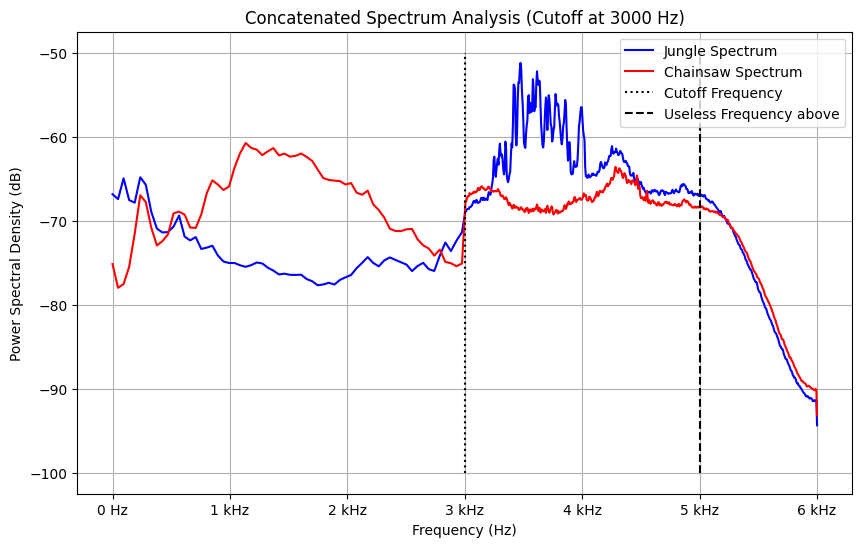

In [16]:
# Filter and concatenate spectra based on the cutoff at 3000 Hz
cutoff_freq = 3000

# Get Mel frequencies and their corresponding spectra below the cutoff
mel_indices = mel_frequencies < cutoff_freq
mel_combined_chainsaw = mel_mean_chainsaw_spectra_db[mel_indices]
mel_combined_jungle = mel_mean_jungle_spectra_db[mel_indices]

# Get original frequencies and their corresponding spectra above the cutoff
f_indices = f > cutoff_freq
jungle_spectra_above = mean_jungle_spectra_db[f_indices]
chainsaw_spectra_above = mean_chainsaw_spectra_db[f_indices]

# Concatenate results
final_jungle_spectra = np.concatenate((mel_combined_jungle, jungle_spectra_above))
final_chainsaw_spectra = np.concatenate((mel_combined_chainsaw, chainsaw_spectra_above))

# Concatenate frequencies for plotting
combined_frequencies = np.concatenate((mel_frequencies[mel_indices], f[f_indices]))

# Plot the concatenated spectra
plt.figure(figsize=(10, 6))
plt.plot(combined_frequencies, final_jungle_spectra, label="Jungle Spectrum", color="blue")
plt.plot(combined_frequencies, final_chainsaw_spectra, label="Chainsaw Spectrum", color="red")
plt.vlines(
    x=3000, ymin=-100, ymax=-50, color="black", linestyles="dotted", label="Cutoff Frequency"
)
plt.vlines(
    x=5000, ymin=-100, ymax=-50, color="black", linestyles="dashed", label="Useless Frequency above"
)
plt.xticks(
    [0, 1000, 2000, 3000, 4000, 5000, 6000],
    ["0 Hz", "1 kHz", "2 kHz", "3 kHz", "4 kHz", "5 kHz", "6 kHz"],
)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB)")
plt.title("Concatenated Spectrum Analysis (Cutoff at 3000 Hz)")
plt.legend()
plt.grid(True)
plt.show()

The current approach is not ideal: jungle sounds are present in all the audio files. Our primary goal is to detect the presence of the engine (chainsaw), not to detect jungle noise! Therefore, we need to focus on its distinctive sound in the low to mid-frequency range.

Additionally, the MEL spectrogram is designed to enhance sensitivity to frequencies within the range of human hearing. However, in this case, we are dealing with an engine, which concentrates most of its energy in lower frequencies.

A possible solution would be to adapt the MEL scale to match the chainsaw's frequency range, maximizing the information in the low to mid-frequency spectrum.

### Cepstral analysis

The chainsaw exhibits some cyclostationary patterns caused by the engine. This is evident from the presence of distinct cepstral components in the spectrogram. To denoise the cepstrum effectively, it is essential to filter out the high-frequency components!

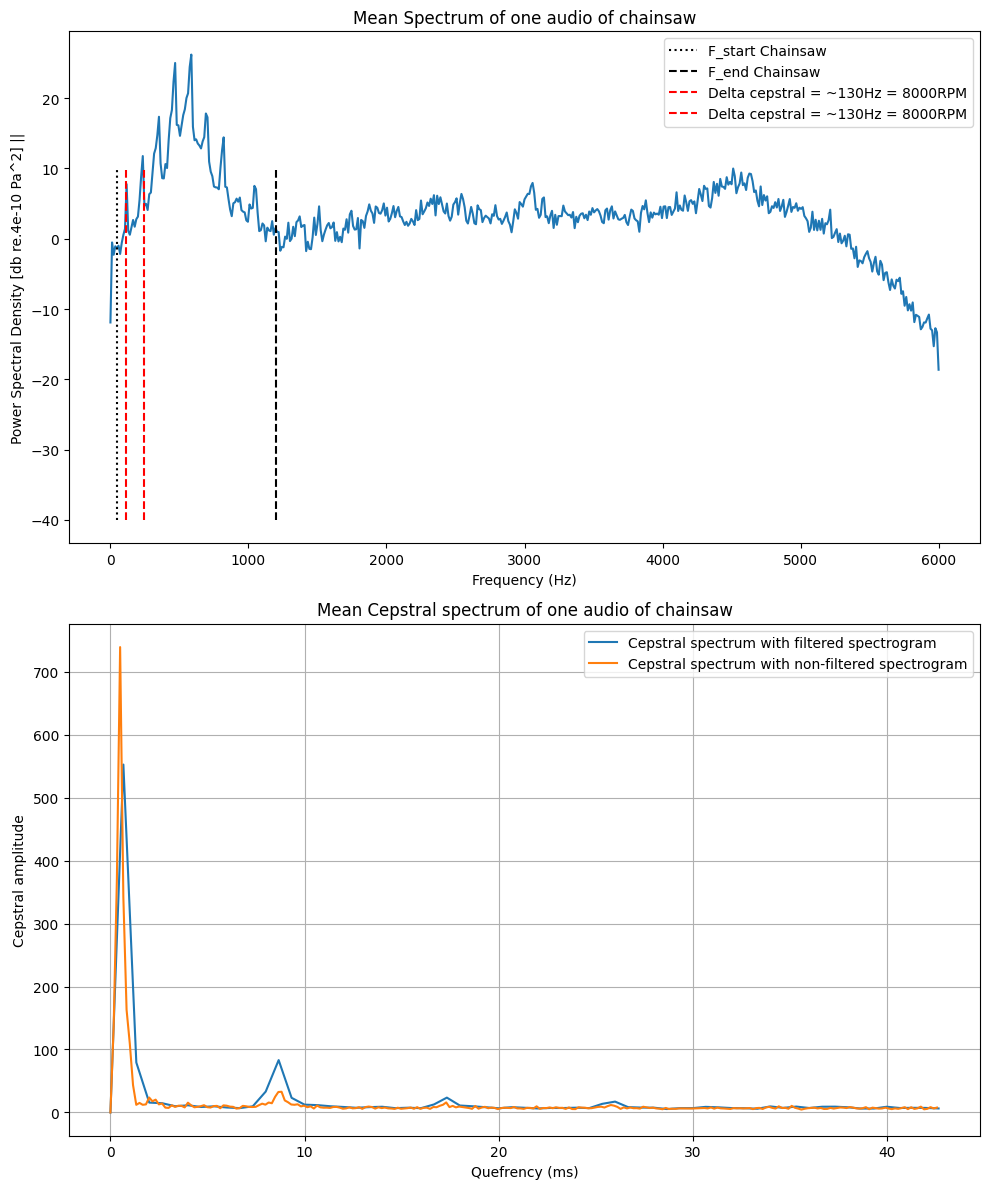

In [122]:
nperseg = 1024
f, t, Sxx_chainsaw = spectrogram(
    chainsaw_audios[2], fs=sig_chainsaw["audio"]["sampling_rate"], nperseg=nperseg
)
reso_f = f[1] - f[0]
f_c, t_c, Cepstre = spectrogram(
    np.log10(Sxx_chainsaw[f < 1500, :]),
    fs=1/reso_f,
    nperseg=Sxx_chainsaw[f < 1500, :].shape[0],
    noverlap=0,
    window="boxcar",
    axis=0,
)
f_c_noised, t_c_noised, Cepstre_noised = spectrogram(
    np.log10(Sxx_chainsaw),
    fs=1/reso_f,
    nperseg=Sxx_chainsaw.shape[0],
    noverlap=0,
    window="boxcar",
    axis=0,
)

Sxx_db = 10 * np.log10(np.abs(Sxx_chainsaw) / 4e-10)
Cepstre_db = np.abs(Cepstre)
Cepstre_db_noised = np.abs(Cepstre_noised)

plt.figure(figsize=(10, 12))
plt.subplot(2, 1, 1)
plt.plot(f, np.mean(Sxx_db, axis=1))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density [db re.4e-10 Pa^2] ||")
plt.title("Mean Spectrum of one audio of chainsaw")
plt.vlines(x=50, ymin=-40, ymax=10, color="black", linestyles="dotted", label="F_start Chainsaw")
plt.vlines(x=1200, ymin=-40, ymax=10, color="black", linestyles="dashed", label="F_end Chainsaw")

plt.vlines(x=110, ymin=-40, ymax=10, color="red", linestyles="dashed", label="Delta cepstral = ~130Hz = 8000RPM")
plt.vlines(x=240, ymin=-40, ymax=10, color="red", linestyles="dashed", label="Delta cepstral = ~130Hz = 8000RPM")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(f_c*1000, np.mean(Cepstre_db, axis=1), label="Cepstral spectrum with filtered spectrogram")
plt.plot(f_c_noised*1000, np.mean(Cepstre_db_noised, axis=1), label="Cepstral spectrum with non-filtered spectrogram")
plt.xlabel("Quefrency (ms)")
plt.ylabel("Cepstral amplitude")
plt.title("Mean Cepstral spectrum of one audio of chainsaw")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [123]:
t_c

array([750.])

We can clearly observe the impact of filtering out the high frequencies from the spectrum before applying the FFT: the peaks, shown in blue, appear much cleaner and less noisy.

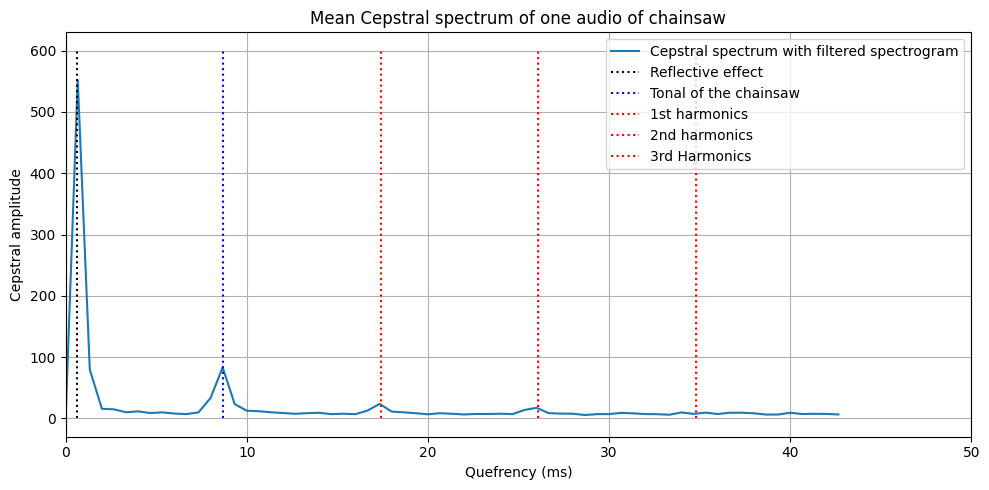

In [124]:
# ZOOM on low quefrencies
plt.figure(figsize=(10, 5))
plt.plot(f_c*1000, np.mean(Cepstre_db, axis=1), label="Cepstral spectrum with filtered spectrogram")
plt.xlabel("Quefrency (ms)")
plt.ylabel("Cepstral amplitude")
plt.title("Mean Cepstral spectrum of one audio of chainsaw")
ymin, ymax=0, 600
plt.vlines(x=0.6, ymin=ymin, ymax=ymax, color="black", linestyles="dotted", label="Reflective effect")
plt.vlines(x=8.7, ymin=ymin, ymax=ymax, color="blue", linestyles="dotted", label="Tonal of the chainsaw")
plt.vlines(x=8.7*2, ymin=ymin, ymax=ymax, color="red", linestyles="dotted", label="1st harmonics")
plt.vlines(x=8.7*3, ymin=ymin, ymax=ymax, color="red", linestyles="dotted", label="2nd harmonics")
plt.vlines(x=8.7*4, ymin=ymin, ymax=ymax, color="red", linestyles="dotted", label="3rd Harmonics")
plt.xlim(0,50)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

The cepstral analysis reveals the following:
- The reflective effect, which is also present when the chainsaw is absent from the recording (see below). A rough estimation of the first reflective plan (the tree branch on which the mic is placed?) is 350ms-1 * 0.6ms = 10cm.
- The tonal component of the chainsaw, detected at a quefrency of approximately 8.7 ms. The engine's speed might be estimated as ( 1 / 0.0087s * 60s ~ 7000 RPM (revolutions per minute).
- Three or four harmonics are clearly detected, likely generated by the mechanical system inside the engine. This may suggest that it is a 4-stroke chainsaw

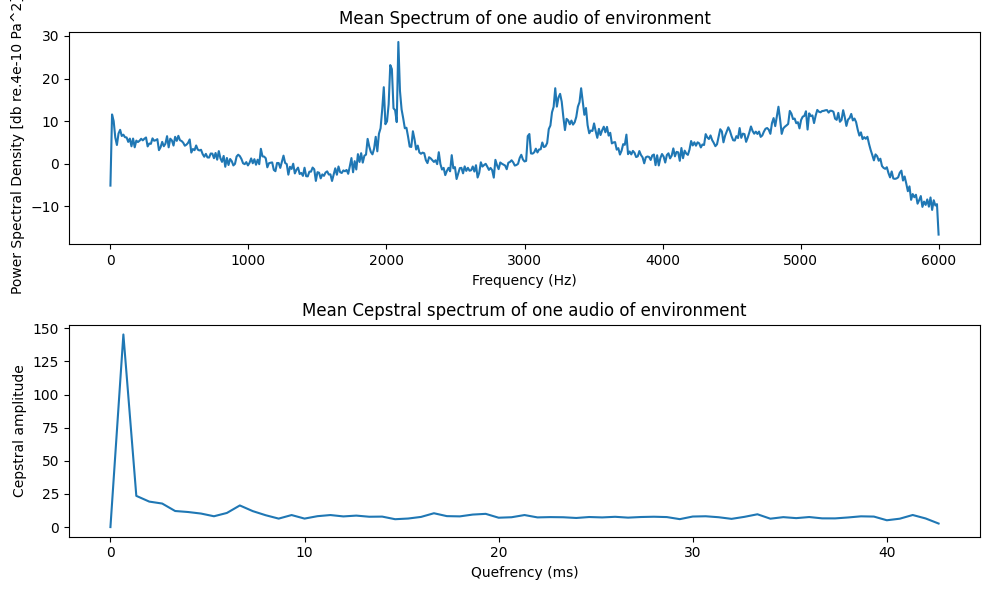

In [116]:
f, t, Sxx_environment = spectrogram(
    jungle_audios[0], fs=sig_environment["audio"]["sampling_rate"], nperseg=nperseg
)
f_c, t_c, Cepstre = spectrogram(
    np.log10(Sxx_environment[f < 1500, :]),
    fs=1/reso_f,
    nperseg=Sxx_environment[f < 1500, :].shape[0],
    noverlap=0,
    window="boxcar",
    axis=0,
)

Sxx_db = 10 * np.log10(np.abs(Sxx_environment) / 4e-10)
Cepstre_db = np.abs(Cepstre)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(f, np.mean(Sxx_db, axis=1))
plt.title("Mean Spectrum of one audio of environment")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density [db re.4e-10 Pa^2] ||")

plt.subplot(2, 1, 2)
plt.plot(f_c*1000, np.mean(Cepstre_db, axis=1))
plt.title("Mean Cepstral spectrum of one audio of environment")
plt.xlabel("Quefrency (ms)")
plt.ylabel("Cepstral amplitude")
plt.tight_layout()
plt.show()

In this case, only the reflective effect is observable in the cepstrum. This is expected, as natural sounds lack cyclostationarity (i.e., no mechanical components). This analysis domain appears to be relevant for the current detection task.

## Compute the cepstral spectrum to 1000 audios

In [117]:
def compute_cepstral_spectrum(audio, sampling_rate, n_fft=1024):
    f, t, Sxx = spectrogram(
        audio, fs=sampling_rate, nperseg=n_fft, window="hann"
    )  # , noverlap=int(0.05*n_fft))
    filtered_sxx = Sxx[(f < 1500), :]
    filtered_sxx = np.log10(filtered_sxx)
    # filtered_sxx = np.diff(np.log10(filtered_sxx, axis=0))
    f_c, t_c, Cepstre = spectrogram(
        filtered_sxx,
        # np.log10(Sxx),
        fs=1/reso_f,
        # nperseg=Sxx[f < 2000, :].shape[0],
        nperseg=filtered_sxx.shape[0],
        noverlap=0,
        window="hann",
        axis=0,
    )
    return np.nanmean(np.abs(Cepstre), axis=1)

In [118]:
cepstres_chainsaw, cepstres_jungle = [], []
n_audio = 10
for chainsaw_audio, jungle_audio in zip(chainsaw_audios[0:5], jungle_audios[0:n_audio]):
    cepstres_chainsaw.append(compute_cepstral_spectrum(chainsaw_audio, SR, n_fft=nperseg))
    cepstres_jungle.append(compute_cepstral_spectrum(jungle_audio, SR, n_fft=nperseg))
cepstres_chainsaw = np.array(cepstres_chainsaw)
cepstres_jungle = np.array(cepstres_jungle)

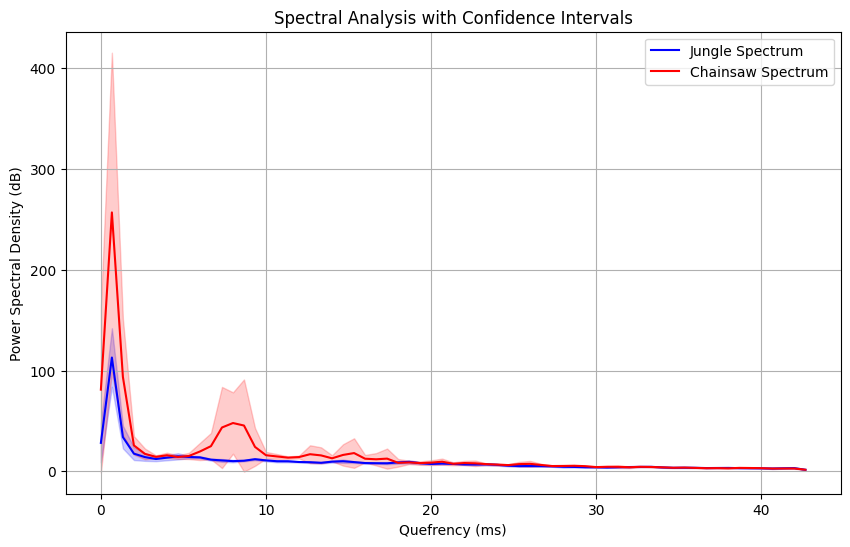

In [119]:
mean_cepstres_jungle = np.mean(cepstres_jungle, axis=0).squeeze()
mean_cepstres_chainsaw = np.mean(cepstres_chainsaw, axis=0).squeeze()
ci_cepstres_jungle = (
    1.96 * np.std(cepstres_jungle, axis=0) / np.sqrt(cepstres_jungle.shape[0])
).squeeze()
ci_cepstres_chainsaw = (
    1.96 * np.std(cepstres_chainsaw, axis=0) / np.sqrt(cepstres_chainsaw.shape[0])
).squeeze()

ci_cepstres_jungle_lower = mean_cepstres_jungle - ci_cepstres_jungle
ci_cepstres_jungle_upper = mean_cepstres_jungle + ci_cepstres_jungle

ci_cepstres_chainsaw_lower = mean_cepstres_chainsaw - ci_cepstres_chainsaw
ci_cepstres_chainsaw_upper = mean_cepstres_chainsaw + ci_cepstres_chainsaw

plt.figure(figsize=(10, 6))
plt.plot(f_c*1000, mean_cepstres_jungle, label="Jungle Spectrum", color="blue")
plt.fill_between(
    f_c*1000,
    ci_cepstres_jungle_lower,
    ci_cepstres_jungle_upper,
    color="blue",
    alpha=0.2,
)
plt.plot(f_c*1000, mean_cepstres_chainsaw, label="Chainsaw Spectrum", color="red")
plt.fill_between(
    f_c*1000,
    ci_cepstres_chainsaw_lower,
    ci_cepstres_chainsaw_upper,
    color="red",
    alpha=0.2,
)
plt.xlabel("Quefrency (ms)")
plt.ylabel("Power Spectral Density (dB)")
plt.title("Spectral Analysis with Confidence Intervals")
plt.legend()
plt.grid(True)
plt.show()

**Remark: The tonal component is clearly THE feature to compute.**

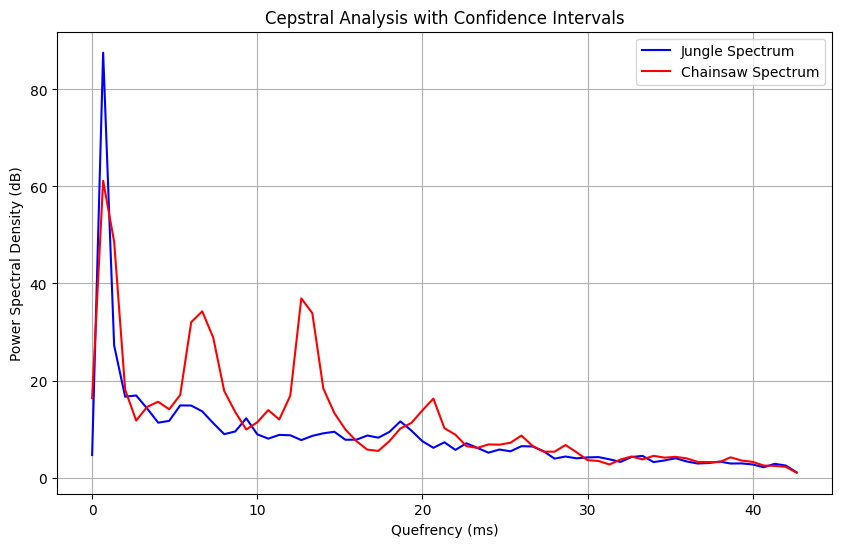

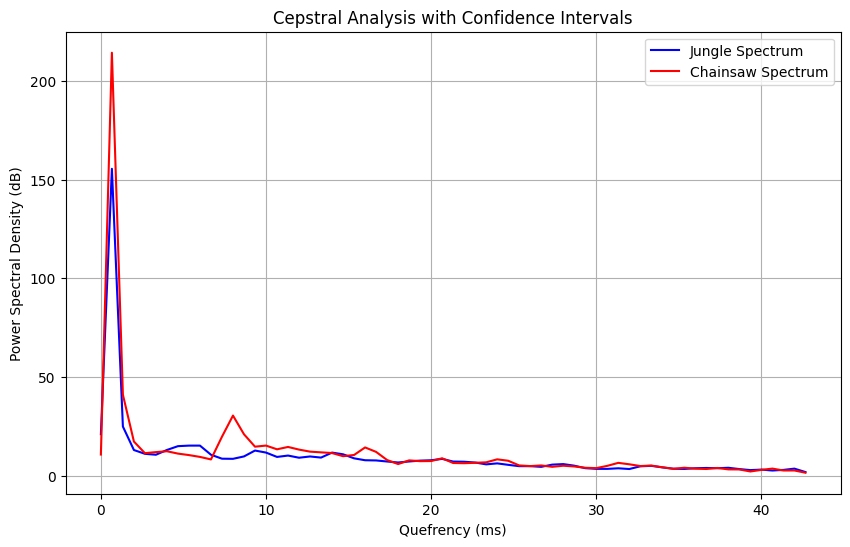

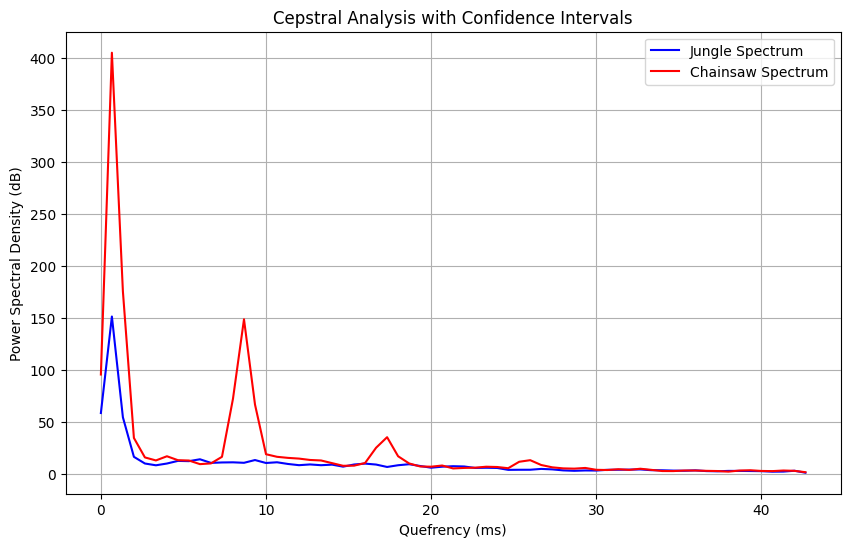

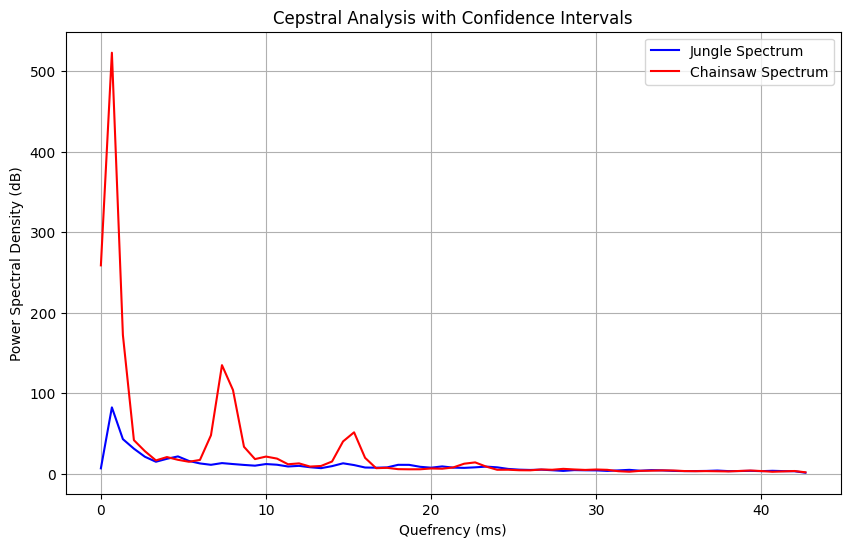

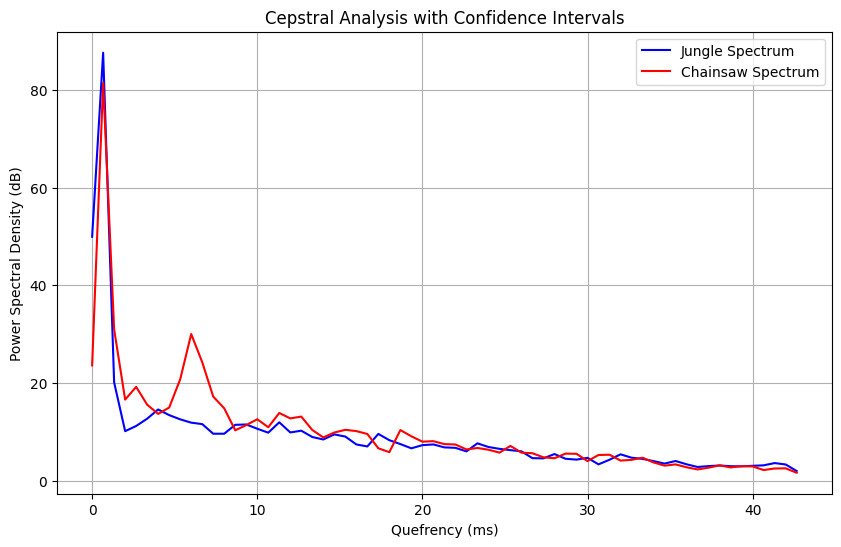

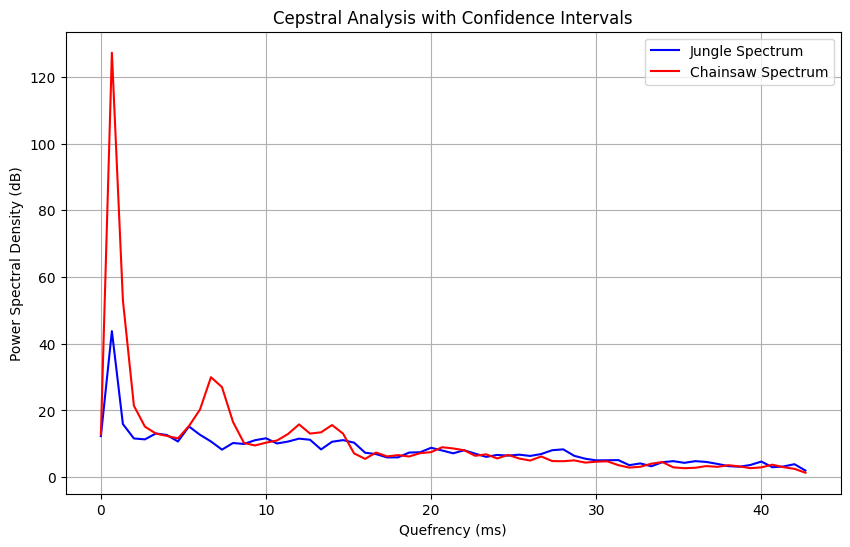

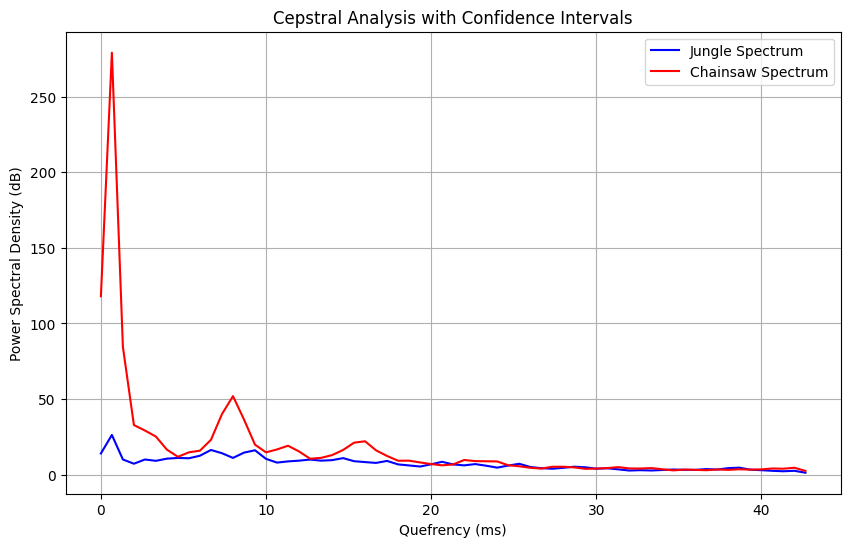

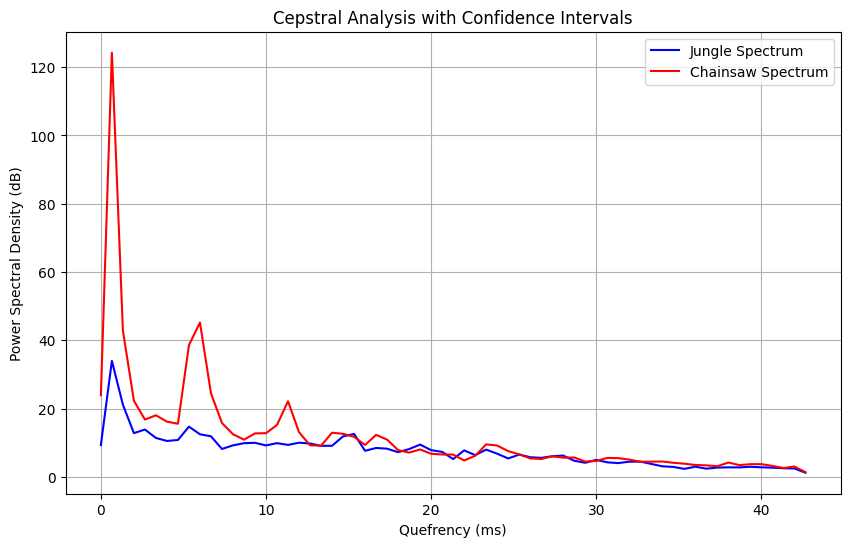

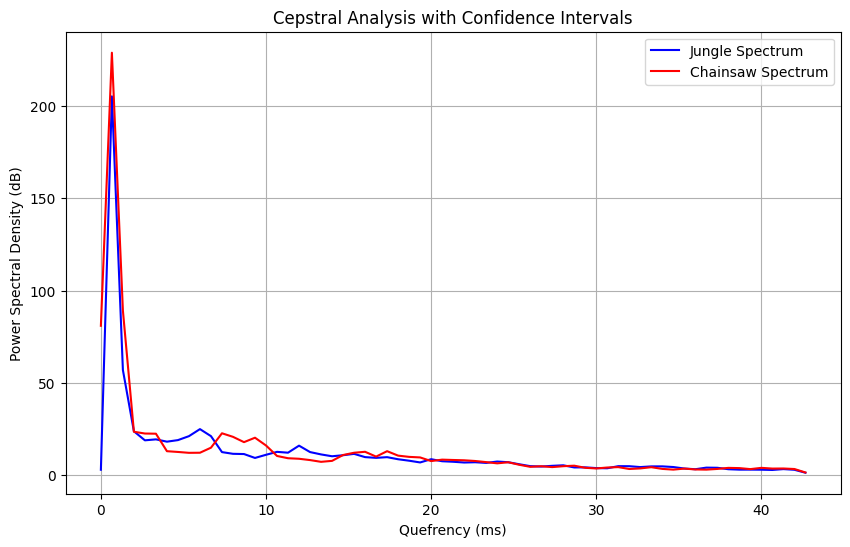

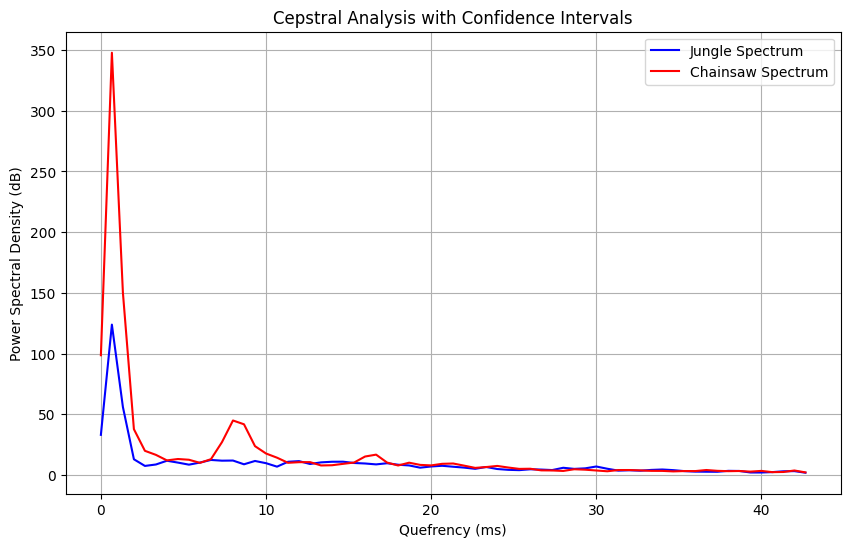

In [120]:
# Few examples
for chainsaw_audio, jungle_audio in zip(chainsaw_audios[0:n_audio], jungle_audios[0:n_audio]):
    cepstres_chainsaw = compute_cepstral_spectrum(chainsaw_audio, SR, n_fft=nperseg)
    cepstres_jungle = compute_cepstral_spectrum(jungle_audio, SR, n_fft=nperseg)
    plt.figure(figsize=(10, 6))
    plt.plot(f_c*1000,cepstres_jungle, label="Jungle Spectrum", color="blue")
    plt.plot(f_c*1000,cepstres_chainsaw, label="Chainsaw Spectrum", color="red")
    # plt.xlim(2, 100)
    # plt.ylim(0, 0.002)
    plt.xlabel("Quefrency (ms)")
    plt.ylabel("Power Spectral Density (dB)")
    plt.title("Cepstral Analysis with Confidence Intervals")
    plt.legend()
    plt.grid(True)
    plt.show()